In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import numpy as np
from pathlib import Path

In [2]:
p = Path('D:/qs-analysis/compiled-data')

files = list(p.glob('**/*.pkl'))
data = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
for f in files:
    family = str(f.parent).split('\\')[-1]
    tmp = pd.read_pickle(f)
    data = data.append(tmp,ignore_index=True)
    #df[['FITC-A','AHL','IPTG']]
#data = pd.read_pickle('LuxSE.pkl')


In [3]:
data

,FITC-A,AHL,IPTG,Family,Replicate
0,7241.040039,1.000000e-06,0.000,Lux,1
1,6172.149902,1.000000e-06,0.000,Lux,1
2,12896.099609,1.000000e-06,0.000,Lux,1
3,11553.089844,1.000000e-06,0.000,Lux,1
4,11425.819336,1.000000e-06,0.000,Lux,1
5,11529.950195,1.000000e-06,0.000,Lux,1
6,10162.910156,1.000000e-06,0.000,Lux,1
7,9304.950195,1.000000e-06,0.000,Lux,1
8,11276.299805,1.000000e-06,0.000,Lux,1
9,15248.370117,1.000000e-06,0.000,Lux,1


In [5]:
def normalize_by_group(df, by):
    groups = df.groupby(by)
    # computes group-wise mean/std,
    # then auto broadcasts to size of group chunk
    Imax = groups.transform(np.max)
    return (df['FITC-A']) / Imax * 100

In [8]:
gb = data.groupby(['AHL','IPTG','Family'])
for group in gb.groups:
    print(group['FITC-A'].mean())

TypeError: tuple indices must be integers or slices, not str

In [6]:
normalize_by_group(data,['AHL','IPTG','Family'])

MemoryError: 

In [ ]:
mean = data.groupby(['AHL','IPTG','Family'])['FITC-A'].apply(gmean).reset_index()
mean = pd.concat([mean,mean.apply(np.log10,axis=0,result_type='broadcast').iloc[:,0]],axis=1)
mean.columns= ['AHL','IPTG','FITC-A','Family','logAHL']
mean = mean.astype({'logAHL': 'int32'})
# normalized
norm = mean.copy()
for fam in norm.Family.unique():
    
    norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100
    
piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])
R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])

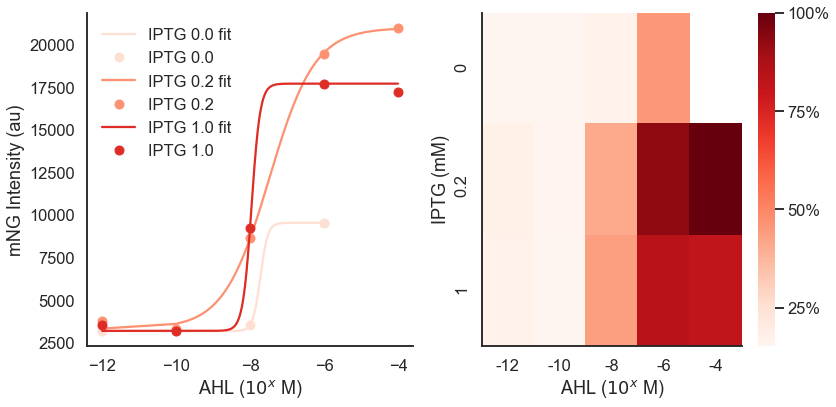

In [5]:
colors = ['#fee0d2','#fc9272','#de2d26']
sns.set_context('talk')
sns.set_style('white')
f, axes = plt.subplots(ncols=2,figsize=(12,6))

# fit Hill function
lines = []  
fits = pd.DataFrame(columns=['AHL','FITC-A','IPTG'])
for i,iptg in enumerate(mean.IPTG.unique()):
    tmp = mean[mean.IPTG==iptg]
    def func(x, a, b):
        return (tmp['FITC-A'].max() -tmp['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + tmp['FITC-A'].min()
    (a_, b_), _ = opt.curve_fit(func, tmp.AHL, tmp['FITC-A'],p0=[1,1e-9],maxfev=10000000)
    n = 1e6
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), int(n))
    y_fit = func(x, a_, b_)
    fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
    lines += axes[0].plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg*1e3))
    lines += axes[0].plot(np.log10(tmp.AHL.values), tmp['FITC-A'].values, 'o',color = colors[i],label='IPTG {:.1f}'.format(iptg*1e3))

labels = [l.get_label() for l in lines]
g = sns.heatmap(piv, cmap='Reds',ax=axes[1])
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
axes[0].set_xlabel(r'AHL ($10^x$ M)')
axes[0].set_ylabel(r'mNG Intensity (au)')

axes[0].legend(labels,frameon=False)
axes[1].set_xlabel(r'AHL ($10^x$ M)')
axes[1].set_ylabel(r'IPTG (mM)')
axes[1].set_yticklabels(['0','0.2','1'])
#f.tight_layout()
#sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues',ax=axes[2])
sns.despine()
#axes[1].xaxis.set_major_formatter(ticker.LogFormatter())
#axes[1].yaxis.set_major_formatter(ticker.ScalarFormatter())
#axes[1].ticklabel_format(axis='both',style='scientific')
f.tight_layout()
f.savefig('LasSE.png',dpi=300)

In [ ]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')
tmpdf = data[data.IPTG==I][['AHL','FITC-A']]
print('IPTG=' +str(I))
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette='Reds')#
#g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    #ax.set_xlim(1e2,2e5)
g.set(xlim=(1e3,1e5))

if I ==0.001:
    g.map(label, "FITC-A")
else:
    g.map(label, "FITC-A")
    for ax in g.axes.flat:
        ax.set_axis_off()
    g.set(xticks=[])

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
#plt.show()
g.savefig('Ridge_Las_IPTG {:.1e}.pdf'.format(I))

IPTG=0.0


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


IPTG=0.0002


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


IPTG=0.001


C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


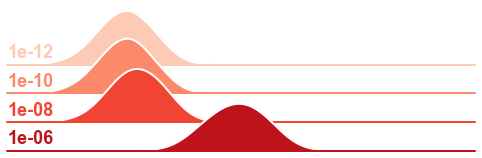

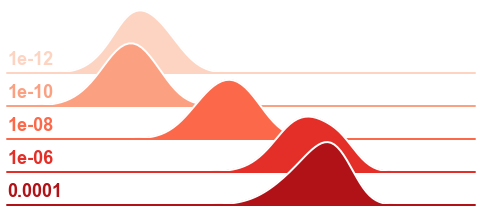

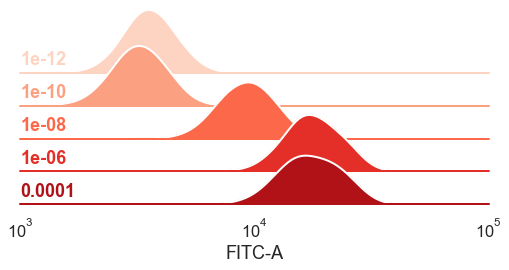

In [7]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')
for I in data.IPTG.unique():
    tmpdf = data[data.IPTG==I][['AHL','FITC-A']]
    print('IPTG=' +str(I))
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette='Reds')#
    #g.set(xlim=(0, 20000))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
    g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    g.set(xlim=(1e3,1e5))

    if I ==0.001:
        g.map(label, "FITC-A")
    else:
        g.map(label, "FITC-A")
        for ax in g.axes.flat:
            ax.set_axis_off()
        g.set(xticks=[])

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    #plt.show()
    g.savefig('Ridge_Las_IPTG {:.1e}.pdf'.format(I))
